# This is the notebook where you can test the best MLP and SVM models on the test set

# Importing the Train, Validation and Test Sets

In [16]:
import torch
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
#We import the necessary libraries.

In [17]:
X_test_df = pd.read_csv('X_Test.csv')
Y_test_df = pd.read_csv('Y_Test.csv')
X_val_df = pd.read_csv('X_Val.csv')
Y_val_df = pd.read_csv('Y_Val.csv')
X_train_df = pd.read_csv('X_Train.csv')
Y_train_df = pd.read_csv('Y_Train.csv')
#We import the train, validation and test sets.

In [18]:
X_Test_Tensor = torch.tensor(X_test_df.values).float()
Y_Test_Tensor = torch.tensor(Y_test_df.values).float()
X_Val_Tensor = torch.tensor(X_val_df.values).float()
Y_Val_Tensor = torch.tensor(Y_val_df.values).float()
X_Train_Tensor = torch.tensor(X_train_df.values).float()
Y_Train_Tensor = torch.tensor(Y_train_df.values).float()
#We convert the values of each dataframe to tensors.

# Testing the Best MLP Model

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class FireAlarmNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size): #We set three parameters for our neural network class. The input 
        #size, the number of hidden neurons and the output size.
        super(FireAlarmNN, self).__init__()
        self.f_c_1 = nn.Linear(input_size, hidden_sizes[0], bias=True) #This is the first fully connected layer. We pass the input
        #features to the first hidden layer. We also include a bias term for each neuron in the hidden layer.
        self.f_c_2 = nn.Linear(hidden_sizes[0], hidden_sizes[1], bias=True) #This is the second fully connected layer. We pass
        #the features from the first hidden layer to the second one and include a bias term for each neuron in the hidden layer.
        self.f_c_3 = nn.Linear(hidden_sizes[1], hidden_sizes[2], bias=True) #This is the third fully connected layer. We pass the
        #features from the second hidden layer to the third hidden layer and inlcude a bias term for each neuron in the hidden
        #layer.
        self.f_c_4 = nn.Linear(hidden_sizes[2], output_size, bias=True) #This is the fourth fully connceted layer. We pass the 
        #features from the third hidden layer to the output layer and incude a bias term for the single neuron in the output 
        #layer.
        self.relu = nn.ReLU() #This is the rectified linear unit activation function. The recitified linear unit activation
        #is a calculation that returns the value 0 if the input value is 0 or less and then for the positive values and returns
        #the input value itself if the input value is positive.

    def forward(self, x): #This is the function that shows the forward propagation of the MLP neural network.
        x = self.f_c_1(x)
        x = self.relu(x)
        x = self.f_c_2(x)
        x = self.relu(x)
        x = self.f_c_3(x)
        x = self.relu(x)
        output = self.f_c_4(x)
        return output
        #We pass the input features through the first fully connected layer and activate the relu activation function in each 
        #forward pass. Then the output of the first fully connected layer becomes the input of the next fully connected layer 
        #etc. After each forward pass we activate the relu function.

    def fit_training_validating(self, train_input_data, train_targets, val_input_data, val_targets, learning_rate, epochs, momentum, weight_decay, patience):
        #This is the part of the neural network which is used to train and validate the model on the given input data and 
        #targets. It applies weight decay for regularization, momentum for optimization and acceleration of the convergence of 
        #gradient descent and early stopping by tracking the validation loss to prevent early stopping during training.
        criterion = nn.BCEWithLogitsLoss() #This is the loss function. We select binary cross-entropy with logits loss since we
        #are dealing with a binary classification problem.
        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=weight_decay) #This is the optimizer that will 
        #update the weights and biases based on the loss function. The adam optimizer is a popular choice for binary 
        #classification problems. We also specify the learning rate, momentum terms (betas) and weight decay for regularization.
        highest_val_loss = float('inf')
        early_stopping_count = 0
        train_losses = [] #We track the training loss for each epoch.
        val_losses = [] #We track the validation loss for each epoch.

        for epoch in range(epochs):
            self.train()  #We first enter training mode.
            predictions = self(train_input_data) #we make predictions on the training set to track the loss.
            loss = criterion(predictions, train_targets.view(-1, 1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item()) #This is the training process of the neural network. For every epoch we feed the inputs forward through the layers,
            #we get the predictions, we calculate the loss function, we then perform backpropagation to get the gradients and
            #then update the weights and biases with the adam function.

            self.eval()  #We enter validation mode and stop training mode.
            with torch.no_grad():
                val_predictions = self(val_input_data)  #We make predictions on the validation set for every epoch.
                val_loss = criterion(val_predictions, val_targets.view(-1, 1))  #We calculate the validation loss.
                val_losses.append(val_loss.item()) #We store every validation loss in the list we created above.
                 

            if val_loss.item() < highest_val_loss:
                highest_val_loss = val_loss.item()
                early_stopping_count = 0
            else:
                early_stopping_count +=1

            if early_stopping_count > patience:
                print(f'Early Stopping at Epoch {epoch}')
                break

        return train_losses, val_losses
    #In the above code we implement the early stopping criteria. If the validation loss keeps increasing over 10 epochs
    #(patience=10) then we stop training because we are overfitting to the training data.

    def predicting(self, X): #This function will be applied on the validation and test set to see how well the model is able to 
        #predict. We will track down the validation accuracies for each model we validate and then calculate the accuracy of the
        #best model with the test set.
        self.eval()  #We enter validation mode.
        with torch.no_grad():
            predictions = self(X)
            final_predictions = torch.sigmoid(predictions) #When the forward propagation is complete, we apply the sigmoid
            #activation function. This transforms the numbers into probabilities of belonging either in class 0 or 1.
            return (final_predictions >= 0.5).int() #We set the threshold to 0.5 . This means that the probabilities that 
        #are equal or over 0.5 are more likely to belong to class 1 and the probabilities that are lower than 0.5 are more 
        #likely to belong to class 0. By calling the .int() we transform the probabilities that are over or equal to 0.5 to 1,
        #and the probabilities under 0.5 to 0.
        
#Reference link for BCEWithLogitsLoss() function: https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy_with_logits.html
#Reference link for Adam optimizer: https://www.analyticsvidhya.com/blog/2023/09/what-is-adam-optimizer/#:~:text=The%20Adam%20optimizer%2C%20short%20for,Developed%20by%20Diederik%20P.

In [20]:
import pickle

#We load the pickle filed with the best model that we saved in the original notebook.
pickle1_file_path = '/Desktop/Masters/Neural Networks/Individual Coursework/Data & Coding/Best_MLP_Model.pkl'

with open(pickle1_file_path, 'rb') as file:
    Best_MLP_Model = pickle.load(file)
    
#Reference link for pickle files: https://www.tutorialspoint.com/how-to-use-pickle-to-save-and-load-variables-in-python

In [21]:
Best_MLP_Model
#This is the structure of the best MLP model.

FireAlarmNN(
  (f_c_1): Linear(in_features=7, out_features=30, bias=True)
  (f_c_2): Linear(in_features=30, out_features=15, bias=True)
  (f_c_3): Linear(in_features=15, out_features=7, bias=True)
  (f_c_4): Linear(in_features=7, out_features=1, bias=True)
  (relu): ReLU()
)

In [22]:
torch.manual_seed(100)

test_predictions = Best_MLP_Model.predicting(X_Test_Tensor)
test_accuracy = accuracy_score(Y_Test_Tensor.numpy(), test_predictions.numpy())
#We test the best model on the test set and generate the accuracy score.

In [23]:
test_accuracy
#This is the test set accuracy for the best MLP model.

0.9527383043269998

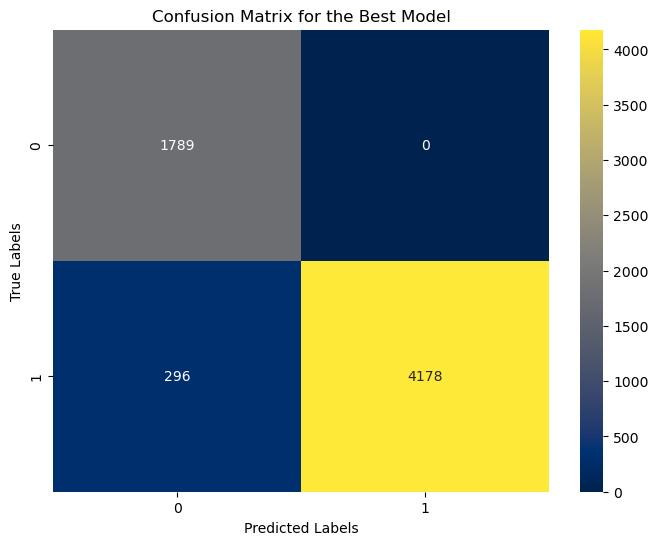

True Negatives: 1789
False Positives: 0
False Negatives: 296
True Positives: 4178
****************************************************************************************************
The test accuracy is 0.9527383043269998
The test precision is 1.0
The test recall is 0.9338399642378185
The test f1-score is 0.965788257050393


In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score


plt.figure(figsize=(8,6))
conf_matrix = confusion_matrix(Y_Test_Tensor.numpy(), test_predictions.numpy())
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='cividis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for the Best Model')
plt.show()

t_n, f_p, f_n, t_p = conf_matrix.ravel()
test_precision = precision_score(Y_Test_Tensor.numpy(), test_predictions.numpy())
test_recall = recall_score(Y_Test_Tensor.numpy(), test_predictions.numpy())
test_f1_score = f1_score(Y_Test_Tensor.numpy(), test_predictions.numpy())


print(f"True Negatives: {t_n}")
print(f"False Positives: {f_p}")
print(f"False Negatives: {f_n}")
print(f"True Positives: {t_p}")
print('*' * 100)
print(f'The test accuracy is {test_accuracy}')
print(f'The test precision is {test_precision}')
print(f'The test recall is {test_recall}')
print(f'The test f1-score is {test_f1_score}')

#We display the confusion matrix of the best MLP model.

#Reference link for confusion matrix: https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/

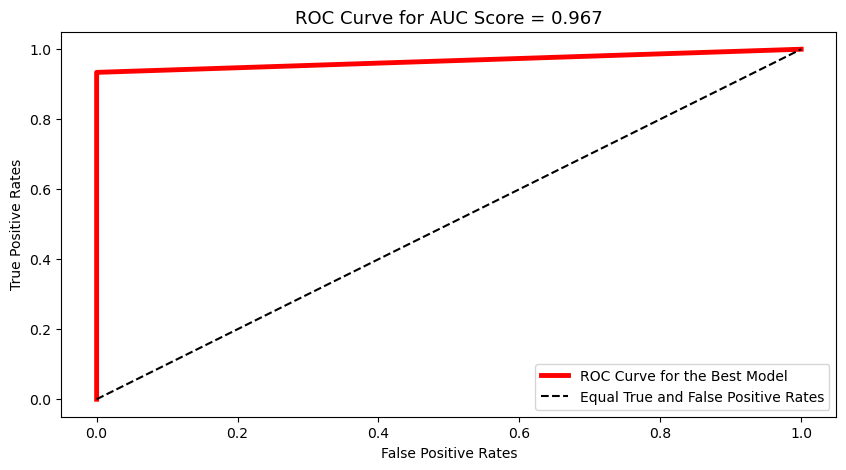

In [25]:
from sklearn.metrics import roc_curve, auc 
false_positive_rates, true_positive_rates, thresholds = roc_curve(Y_Test_Tensor, test_predictions) 
AUC_Score = auc(false_positive_rates, true_positive_rates) 

plt.figure(figsize=(10,5))
plt.plot(false_positive_rates, true_positive_rates, color='red', lw=3.5, label=f'ROC Curve for the Best Model')
plt.plot([0,1], [0,1], color='black', lw=1.5, linestyle='--', label='Equal True and False Positive Rates')
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.title(f'ROC Curve for AUC Score = {round(AUC_Score,3)}', fontsize=13)
plt.legend(loc='lower right')

plt.show()
#We display the ROC Curve for the best MLP model to compare the true and false positive rates. We want to see the trade-offs between
#the true and false positive rates.

#Reference link for ROC Curve: https://www.w3schools.com/python/python_ml_auc_roc.asp

# Testing the Best SVM Model

In [26]:
import pickle

#We load the pickle filed with the best model that we saved in the original notebook.
pickle2_file_path = '/Desktop/Masters/Neural Networks/Individual Coursework/Data & Coding/Best_SVM_Model.pkl'

with open(pickle2_file_path, 'rb') as file:
    Best_SVM_Model = pickle.load(file)
    
#Reference link for pickle files: https://www.tutorialspoint.com/how-to-use-pickle-to-save-and-load-variables-in-python

In [27]:
Best_SVM_Model
#This is the best SVM model

SVC(C=100, gamma=0.1)

In [28]:
torch.manual_seed(100)
Test_Predictions = Best_SVM_Model.predict(X_Test_Tensor) 
Test_Accuracy = accuracy_score(Y_Test_Tensor, Test_Predictions)
print("Test Accuracy With the Best Parameters:", Test_Accuracy)
#We calculate and print the test accuracy.

Test Accuracy With the Best Parameters: 0.8958965352067699


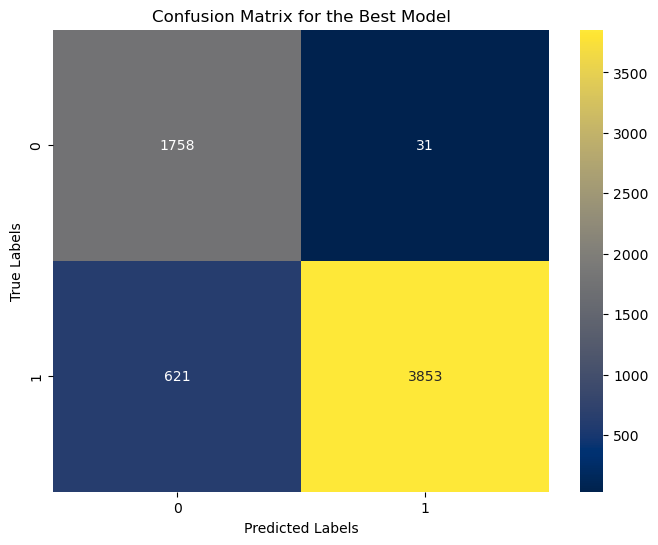

True Negatives: 1758
False Positives: 31
False Negatives: 621
True Positives: 3853
****************************************************************************************************
The test accuracy is 0.8958965352067699
The test precision is 0.9920185375901133
The test recall is 0.8611980330800179
The test f1-score is 0.92199090691553


In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

Confusion_Matrix = confusion_matrix(Y_Test_Tensor, Test_Predictions)

plt.figure(figsize=(8,6))
sns.heatmap(Confusion_Matrix, annot=True, fmt='d', cmap='cividis')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for the Best Model')
plt.show()

t_n, f_p, f_n, t_p = Confusion_Matrix.ravel()
Test_Precision = precision_score(Y_Test_Tensor.numpy(), Test_Predictions)
Test_Recall = recall_score(Y_Test_Tensor.numpy(), Test_Predictions)
Test_F1_Score = f1_score(Y_Test_Tensor.numpy(), Test_Predictions)

#We display the confusion matrix.
print(f"True Negatives: {t_n}")
print(f"False Positives: {f_p}")
print(f"False Negatives: {f_n}")
print(f"True Positives: {t_p}")
print('*' * 100)
print(f'The test accuracy is {Test_Accuracy}')
print(f'The test precision is {Test_Precision}')
print(f'The test recall is {Test_Recall}')
print(f'The test f1-score is {Test_F1_Score}')

#Reference link for confusion matrix: https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/

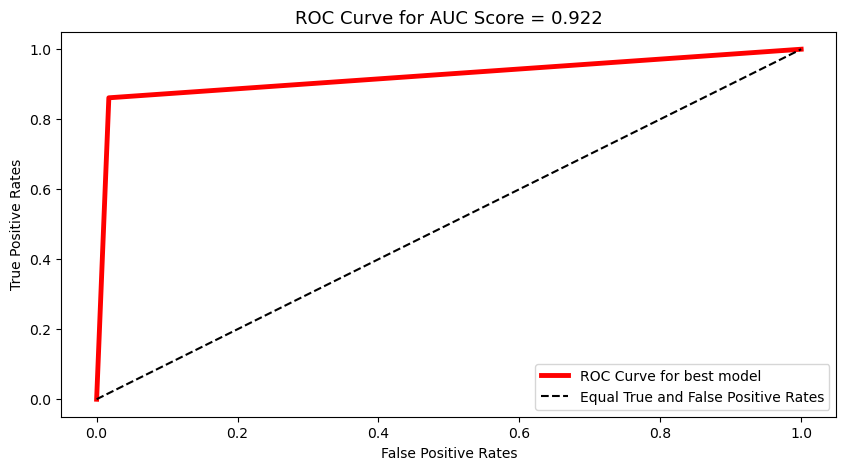

In [30]:
from sklearn.metrics import roc_curve, auc 
false_positive_rates, true_positive_rates, thresholds = roc_curve(Y_Test_Tensor, Test_Predictions) 
AUC_Score = auc(false_positive_rates, true_positive_rates) 

plt.figure(figsize=(10,5))
plt.plot(false_positive_rates, true_positive_rates, color='red', lw=3.5, label=f'ROC Curve for best model')
plt.plot([0,1], [0,1], color='black', lw=1.5, linestyle='--', label='Equal True and False Positive Rates')
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.title(f'ROC Curve for AUC Score = {round(AUC_Score,3)}', fontsize=13)
plt.legend(loc='lower right')
plt.show()
#We display the ROC Curve for the best SVM model to compare the true and false positive rates. We want to see the trade-offs between
#the true and false positive rates.

#Reference link for ROC Curve: https://www.w3schools.com/python/python_ml_auc_roc.asp